In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.cifar_resnet import *
from lib.adv_model import *
from lib.dknn_attack import DKNNAttack
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNN, DKNNL2
from lib.utils import *
from lib.lip_model import *
from lib.knn import *
from lib.nin import *
from lib.cifar10_model import *

from lib.cifar10_dcgan import Discriminator, Generator

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_cifar10_all(
    '/data', val_size=0.1, seed=seed)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


---

Load Models

In [6]:
exp_id = 2

model_name = 'cifar10_resnet_exp%d.h5' % exp_id
# model_name = 'adv_cifar10_exp%d.h5' % exp_id
# model_name = 'train_cifar10_vae_exp%d.h5' % exp_id
# model_name = 'rot_cifar10_exp%d.h5' % exp_id
# model_name = 'ae_cifar10_exp%d.h5' % exp_id

In [7]:
net = PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=10)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True
net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.module
net = net.eval().to('cuda')

In [52]:
net = PreActResNet(PreActBlock, [2, 2, 2, 2]).eval()
config = {'num_steps': 8,
          'step_size': 0.05,
          'random_start': True,
          'loss_func': 'xent'}
net = PGDL2Model(net, config)

net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.basic_net
net = net.eval().to('cuda')

In [ ]:
net = CIFAR10_VAE((3, 32, 32), latent_dim=128)
net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.eval().to('cuda')

In [57]:
net = PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=4)
net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.eval().to('cuda')

In [44]:
net = CIFAR10_AE((3, 32, 32), latent_dim=128)
net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.eval().to('cuda')

In [8]:
net

PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d

In [8]:
ind = np.zeros(x_test.size(0))
with torch.no_grad():
    num = 0
    for i in range(x_test.size(0) // 100):
        begin = i * 100
        end = (i + 1) * 100
        y_pred = net(x_test[begin:end].to('cuda'))
        ind[begin:end] = (y_pred.argmax(1).cpu() == y_test[begin:end]).numpy()
        num += (y_pred.argmax(1).cpu() == y_test[begin:end]).sum().numpy()
    print(num / y_test.size(0))
ind = np.where(ind)[0]

0.9303


In [73]:
ind = ind[:100]

In [74]:
attack = CWL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=False,
            binary_search_steps=5, max_iterations=500,
            confidence=0, learning_rate=1e-1,
            initial_const=1e-2, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[ind].cuda(), y_test[ind].cuda(), 100)

    step: 0; loss: 0.031; l2dist: 0.000
    step: 50; loss: 0.037; l2dist: 0.082
binary step: 0; number of successful adv: 0/100
    step: 0; loss: 0.308; l2dist: 0.000
    step: 50; loss: 0.301; l2dist: 0.155
    step: 100; loss: 0.293; l2dist: 0.113
    step: 150; loss: 0.293; l2dist: 0.113
    step: 200; loss: 0.293; l2dist: 0.113
binary step: 1; number of successful adv: 2/100
    step: 0; loss: 3.035; l2dist: 0.000
    step: 50; loss: 1.732; l2dist: 0.924
    step: 100; loss: 1.723; l2dist: 0.918
    step: 150; loss: 1.726; l2dist: 0.918
binary step: 2; number of successful adv: 42/100
    step: 0; loss: 19.278; l2dist: 0.000
    step: 50; loss: 2.523; l2dist: 1.353
    step: 100; loss: 2.549; l2dist: 1.363
binary step: 3; number of successful adv: 90/100
    step: 0; loss: 36.908; l2dist: 0.000
    step: 50; loss: 2.900; l2dist: 1.422
    step: 100; loss: 2.746; l2dist: 1.384
    step: 150; loss: 2.665; l2dist: 1.378
    step: 200; loss: 2.779; l2dist: 1.435
binary step: 4; numbe

In [18]:
ind_adv = np.zeros(x_adv.size(0))
with torch.no_grad():
    num = 0
    for i in range(x_adv.size(0) // 100):
        begin = i * 100
        end = (i + 1) * 100
        y_pred = net(x_adv[begin:end].to('cuda'))
        ind_adv[begin:end] = (y_pred.argmax(1).cpu() != y_test[ind][begin:end]).numpy()
        num += (y_pred.argmax(1).cpu() == y_test[ind][begin:end]).sum().numpy()
    print(num / x_adv.size(0))
ind_adv = np.where(ind_adv)[0]

0.0


In [18]:
pert = (x_adv.cpu() - x_test[ind]).view(x_adv.size(0), -1).norm(2, 1)
d1 = (len(ind) - (pert[ind_adv] < 0.5).sum().numpy()) / y_test.size(0)
d2 = (len(ind) - (pert[ind_adv] < 1).sum().numpy()) / y_test.size(0)
d3 = (len(ind) - (pert[ind_adv] < 1.5).sum().numpy()) / y_test.size(0)
print('& %.4f & %.4f & %.4f' % (d1, d2, d3))

& 0.0012 & 0.0001 & 0.0001


In [19]:
pert[ind_adv].mean()

tensor(0.1429)

---

## DkNN

In [9]:
layers = ['layer4']

dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=75, num_classes=10)

In [10]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.9301


In [47]:
# Load x_adv from file
# Skip this if you you want to generate attacks on the notebook

x_adv = pickle.load(open('x_adv/x_adv_cifar10_resnet_exp2.h5.p', 'rb'))

with torch.no_grad():
    y_pred = dknn.classify(x_adv)
    ind_adv = np.where(y_pred.argmax(1) != y_test[ind].numpy())[0]
    print((y_pred.argmax(1) == y_test[ind].numpy()).sum() / y_pred.shape[0])

In [12]:
from lib.dknn_attack_l2 import DKNNL2Attack
attack = DKNNL2Attack()

def attack_batch(x, y, batch_size, layer):
    x_a = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_a[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            guide_layer=layer, m=300, binary_search_steps=10,
            max_iterations=500, learning_rate=1e-2, initial_const=1e-5,
            abort_early=False, random_start=True, guide=2)
    return x_a

num = 100
ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
x_adv = attack_batch(x_test[ind][:num].cuda(), y_test[ind][:num], 100, layers[0])

    step: 0; loss: 12.708; l2dist: 0.217
    step: 50; loss: 2.808; l2dist: 0.588
    step: 100; loss: 2.620; l2dist: 0.459
    step: 150; loss: 2.592; l2dist: 0.442
    step: 200; loss: 2.583; l2dist: 0.436
    step: 250; loss: 2.578; l2dist: 0.434
    step: 300; loss: 2.575; l2dist: 0.433
    step: 350; loss: 2.574; l2dist: 0.432
    step: 400; loss: 2.573; l2dist: 0.432
    step: 450; loss: 2.573; l2dist: 0.432
tensor(100., device='cuda:0')
binary step: 0; number of successful adv: 100/100
    step: 0; loss: 6.368; l2dist: 0.217
    step: 50; loss: 1.452; l2dist: 0.438
    step: 100; loss: 1.384; l2dist: 0.381
    step: 150; loss: 1.375; l2dist: 0.375
    step: 200; loss: 1.372; l2dist: 0.374
    step: 250; loss: 1.371; l2dist: 0.373
    step: 300; loss: 1.369; l2dist: 0.372
    step: 350; loss: 1.369; l2dist: 0.372
    step: 400; loss: 1.370; l2dist: 0.373
    step: 450; loss: 1.370; l2dist: 0.373
tensor(100., device='cuda:0')
binary step: 1; number of successful adv: 100/100
    s

(array([97.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.065 , 0.1585, 0.252 , 0.3455, 0.439 , 0.5325, 0.626 , 0.7195,
        0.813 , 0.9065, 1.    ]),
 <a list of 10 Patch objects>)

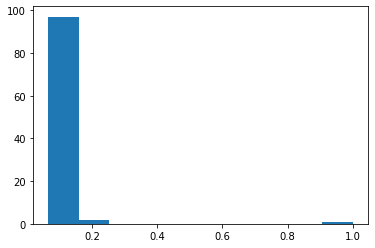

In [14]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [22]:
y_pred = dknn.classify(x_adv)
acc = (y_pred.argmax(1) == y_test[ind][:num].numpy()).sum() / len(y_pred)
print('Accuracy on x_adv: %.4f' % acc)

ind_adv = np.where(y_pred.argmax(1) != y_test[ind][:num].numpy())[0]
dist = np.sqrt(np.sum((x_adv.cpu().detach().numpy() - x_test.numpy()[ind][:num])[ind_adv]**2, (1, 2, 3)))
print('Mean distance: %.4f' % np.mean(dist))

Accuracy on x_adv: 0.0000
Mean distance: 0.1499


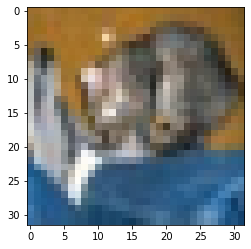

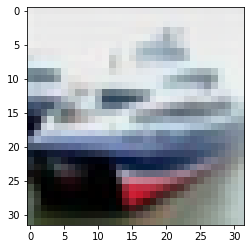

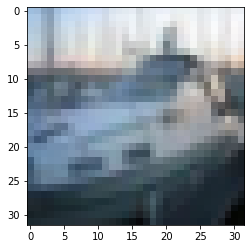

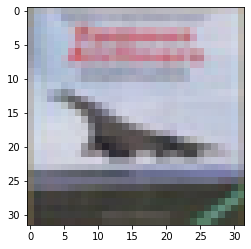

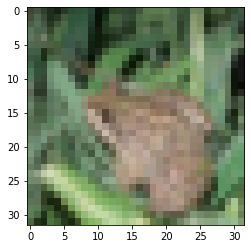

In [23]:
for i in range(5):
    plt.imshow(x_adv[i].cpu().detach().permute(1, 2, 0).numpy())
    plt.show()

---

## RotNet

Train small network on top of pre-trained rotation network

In [27]:
opt = {'num_classes': 4, 'num_stages': 4}
net = NetworkInNetwork(opt)

In [28]:
net.load_state_dict(torch.load('saved_models/model_net_epoch200')['network'])

In [29]:
net = net._feature_blocks

In [30]:
net_wrap = NINWrapper(net, block=2)
net_wrap = net_wrap.cuda().eval()

In [33]:
# net_wrap.fc = nn.Sequential(
#     nn.Linear(12288, 200),
#     nn.ReLU(inplace=True),
#     nn.Linear(200, 200),
#     nn.ReLU(inplace=True),
#     nn.Linear(200, 128))
net_wrap.fc = nn.Sequential(
    nn.Linear(12288, 2000),
    nn.ReLU(inplace=True),
    nn.Linear(2000, 400),
    nn.ReLU(inplace=True),
    nn.Linear(400, 128))
net_wrap = net_wrap.to('cuda')

In [44]:
net_wrap.load_state_dict(torch.load('saved_models/transfer_cifar10_exp11.h5'))

In [81]:
net = PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=4)
net.load_state_dict(torch.load('saved_models/rot_cifar10_exp0.h5'))
net_wrap = ResNetWrapper(net, block=3, dim=16384)
for param in net_wrap.parameters():
    param.requires_grad = False
# net_wrap.fc = nn.Sequential(
#     nn.Linear(16384, 2000),
#     nn.ReLU(inplace=True),
#     nn.Linear(2000, 400),
#     nn.ReLU(inplace=True),
#     nn.Linear(400, 128),
# )
net_wrap.fc = nn.Sequential(
    nn.BatchNorm1d(16384),
    nn.Linear(16384, 2000),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(2000),
    nn.Linear(2000, 400),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(400),
    nn.Linear(400, 128),
)
net_wrap.load_state_dict(torch.load('saved_models/transfer_cifar10_exp18.h5'))
net_wrap = net_wrap.to('cuda').eval()

In [82]:
layers = ['fc']

dknn = DKNNL2(net_wrap, x_train, y_train, x_valid, y_valid, layers, 
              k=1, num_classes=10)

In [101]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.7015


In [99]:
with torch.no_grad():
    num = 0
    for i in range(x_test.size(0) // 100):
        begin = i * 100
        end = (i + 1) * 100
        y_pred = net_wrap(x_test[begin:end].to('cuda'))
        num += (y_pred.argmax(1).cpu() == y_test[begin:end]).sum().numpy()
    print(num / y_test.size(0))

0.0011


In [59]:
x_adv = pickle.load(open('x_adv/x_adv_adv_cifar10_exp0.h5.p', 'rb'))
# x_adv = pickle.load(open('x_adv/x_ba_cifar10_adv2_0.2_0.001.p', 'rb'))
# x_adv = pickle.load(open('x_adv/x_adv_cifar10_resnet_exp2.h5.p', 'rb'))

In [56]:
torchvision.utils.save_image(x_adv[:10], 'cifar10_cw_adv.png', nrow=10, padding=0)

In [10]:
torchvision.utils.save_image(x_test[:10], 'cifar10_test.png', nrow=10, padding=0)

In [75]:
diff = x_adv[:10].cpu() - x_test[:10]
torchvision.utils.save_image(diff, 'diff_cw_adv.png', nrow=10, padding=0, normalize=True)

In [50]:
(x_adv - x_test[ind])[:100].view(100, -1).norm(2, 1)

tensor([0.1601, 0.1639, 0.0439, 0.0925, 0.2344, 0.1875, 0.1263, 0.0629, 0.1313,
        0.0308, 0.1699, 0.2601, 0.1186, 0.2549, 0.2104, 0.0949, 0.0168, 0.1908,
        0.2373, 0.2276, 0.0749, 0.1144, 0.0599, 0.3487, 0.0113, 0.1286, 0.0399,
        0.1052, 0.1184, 0.1812, 0.1033, 0.1054, 0.1015, 0.0491, 0.2473, 0.1405,
        0.1351, 0.3051, 0.2656, 0.1246, 0.1826, 0.1177, 0.1306, 0.2810, 0.2485,
        0.0251, 0.0446, 0.2726, 0.0799, 0.2484, 0.1870, 0.0150, 0.0376, 0.1555,
        0.1845, 0.0784, 0.0302, 0.0403, 0.0080, 0.1847, 0.1957, 0.1100, 0.0935,
        0.1443, 0.0339, 0.1736, 0.0629, 0.1216, 0.0863, 0.1177, 0.0650, 0.1191,
        0.1149, 0.3842, 0.2538, 0.1573, 0.1572, 0.1589, 0.0625, 0.2314, 0.1450,
        0.0575, 0.0426, 0.0426, 0.0458, 0.2055, 0.2434, 0.1804, 0.0808, 0.2458,
        0.2491, 0.0758, 0.0949, 0.1004, 0.0661, 0.2742, 0.2168, 0.0666, 0.0765,
        0.2380])

In [ ]:
(x_adv.cpu() - x_test[ind][:100]).view(100, -1).norm(2, 1)